In [1]:
from __future__ import division
import numpy as np
from env_large import *
from collections import defaultdict
import random
from graphviz import Source
from itertools import count
import matplotlib.pyplot as plt
import tensorflow as tf
import time

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def is_accept(s):
    s = np.unravel_index(s, env.shape)
    if s[2] in env.rabin.accept:
        return True
    return False

def is_reject(s):
    s = np.unravel_index(s, env.shape)
    if s[2] in env.rabin.reject:
        return True
    return False

def coord_to_direct(new_state, last_state):
    new_state = np.array(np.unravel_index(new_state, env.shape)[:-1])
    last_state = np.array(np.unravel_index(last_state, env.shape)[:-1])
    diff = new_state - last_state
    if diff[0] == 1 and diff[1] == 0:
        return 2
    elif diff[0] == 0 and diff[1] == 1:
        return 1
    elif diff[0] == -1 and diff[1] == 0:
        return 0
    elif diff[0] == 0 and diff[1] == -1:
        return 3
    elif diff[0] == 0 and diff[1] == 0:
        return 4
    
def get_reward(state):
    if is_accept(state):
        return 10
    elif is_reject(state):
        return -10
    else:
        return 0

def max_pu(state):
    next_q = np.zeros(env.nA)
    for action in range(env.nA):
        next_q[action] = np.sum([P[state][action][next_state]*Utilities[next_state] for next_state in P[state][action].keys()])
    return np.max(next_q)

def argmax_q(state):
    q = np.zeros(env.nA)
    for action in range(env.nA):
        q[action] = np.sum([P[state][action][next_state]*Utilities[next_state] for next_state in P[state][action].keys()])
    return np.argmax(q)

def greedy_action(state, truncation):
    action = Opt_Policy[state]
    rand_num = random.random()
    if rand_num <= truncation:
        return np.random.randint(4)
    return action
    

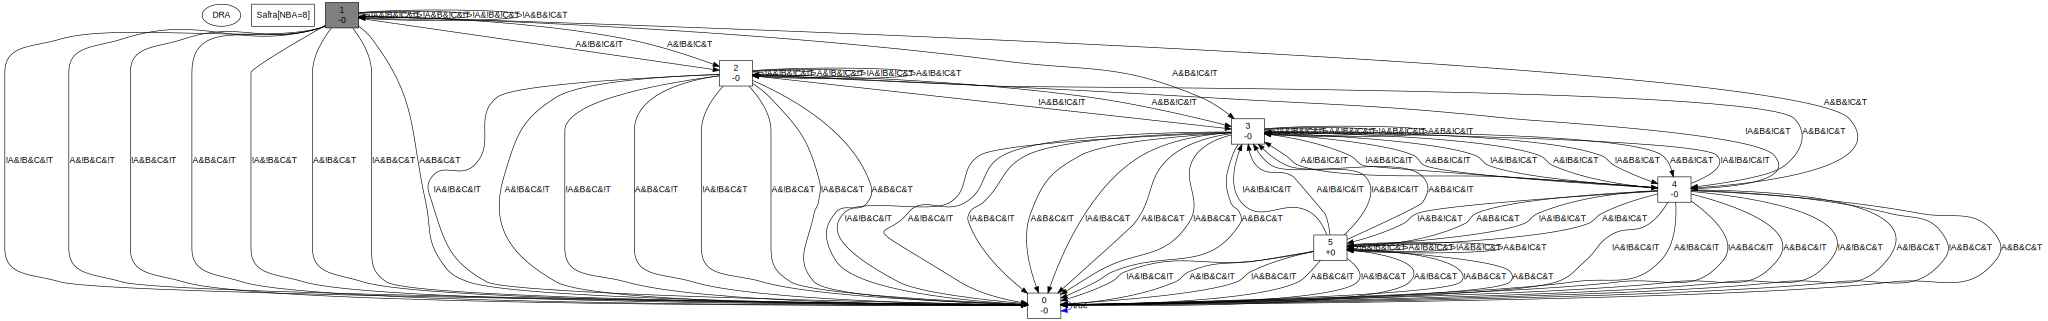

In [3]:
env = CurrentWorld("<>(A && <>B) && []!C")
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [4]:
ALPHA = 0.5
GAMMA = 0.99
SEED = 666
MAX_EPI = 10000
MAX_STEP = 3000
EXPLORATION = 0.2
random.seed(SEED)
np.random.seed(SEED)
SUMMARY_DIR = "./results/" + time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")

In [5]:
Utilities = {s : 0 for s in range(env.nS)}
State_Frequency = defaultdict(lambda: np.zeros(env.nA))
Outcome = defaultdict(lambda: {a : {} for a in range(env.nA)})
P = defaultdict(lambda: {a : {} for a in range(env.nA)})
Opt_Policy = {s : 0 for s in range(env.nS)}
state_list = []
reward_list = []

# fig, ax = plt.subplots()

episode_reward = tf.Variable(0.)
tf.summary.scalar("Reward", episode_reward)
exploration = tf.Variable(0.)
tf.summary.scalar("Exploration", exploration)
lr = tf.Variable(0.)
tf.summary.scalar("Learning_Rate", lr)

summary_vars = [episode_reward, exploration, lr]
summary_ops = tf.summary.merge_all()
writer = tf.summary.FileWriter(SUMMARY_DIR)

In [ ]:
with tf.Session() as sess:
    for epi in range(MAX_EPI):
        state = env.reset()
        last_state = None
        last_action = None
        epi_reward = 0
        done = False
        for step in count():
            if state not in state_list:
                state_list += [state]
                if is_accept(state):
                    Utilities[state] = 10
                elif is_reject(state):
                    Utilities[state] = -10
                else:
                    Utilities[state] = 0

            if last_state is not None:
                State_Frequency[last_state][last_action] += 1
                if state not in Outcome[last_state][last_action].keys():
                    Outcome[last_state][last_action][state] = 1
                else: 
                    Outcome[last_state][last_action][state] += 1
#                 for s in Outcome.keys():
#                     for a in Outcome[s].keys():
#                         for t in Outcome[s][a]:
#                             if Outcome[s][a][t] != 0:
#                                 P[s][a][t] = Outcome[s][a][t] / State_Frequency[s][a]
                for t in Outcome[last_state][last_action]:
                    if Outcome[last_state][last_action][t] != 0:
                        P[last_state][last_action][t] = Outcome[last_state][last_action][t] / State_Frequency[last_state][last_action]
                
                Utilities[last_state] = (1 - ALPHA)*Utilities[last_state] + ALPHA*(get_reward(state) + 
                                                                                   GAMMA*max_pu(last_state) )
                Opt_Policy[last_state] = argmax_q(last_state)

            action = greedy_action(state, EXPLORATION)

            last_state = state
            last_action = action
            state,_,done,_ = env.step(action)

            epi_reward += get_reward(state)
            
            if done and EXPLORATION > 0.05:
                EXPLORATION = EXPLORATION*1
                
            if done:
                ALPHA = ALPHA*1
            
            if done or step >= MAX_STEP:
#                 reward_list += [epi_reward]
#                 print "\rEPI: %i| STEP: %i| REWARD: %i" %(epi, step, epi_reward),
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(epi_reward)) 
                        +" | Episode: " + str(epi) 
                        + " | Step: " + str(step) 
                        + " | Exploration: " + str(EXPLORATION)
                        + " | Learning_Rate: " + str(ALPHA)
                        + "\n")
                f.close()
                
                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: epi_reward,  
                    summary_vars[1]: EXPLORATION,
                    summary_vars[2]: ALPHA
                })
                writer.add_summary(summary_str, epi)
                writer.flush()
                
#                 if epi%10 == 0:
#                     ax.clear()
#                     ax.plot(range(epi+1), reward_list)
#                     plt.pause(0.001)
                break



In [ ]:
plot_path(env)

In [ ]:
with open("opt_policy.txt", "w") as myfile:
    myfile.write(str(Opt_Policy))

In [ ]:
with open("transit_probs.txt", "w") as myfile:
    myfile.write(str(P))

In [ ]:
plt.close("all")

In [ ]:
def plot_path(env):
    # env = CurrentWorld(LTL)
    num_fig = 0
    
    state_dim = 3
    action_dim = 5

    state = env.reset()
    done = False

    while not done:
        action = Opt_Policy[state]
        state = np.reshape(list(np.unravel_index(state, env.shape)), (1, state_dim))
        state_for_plot = tuple(state[0][:2])
        next_state,_,done,_ = env.step(action)
        render(env, state_for_plot, action)
        state = next_state
        num_fig += 1
        if num_fig%50 == 0:
            plt.close("all")

def render(env, state, action):
    action_dict = {0:"UP", 1:"RIGHT", 2:"DOWN", 3:"LEFT", 4: "NONE"}
    world = np.zeros((env.shape[0], env.shape[1]))
    color_dict = {ap: color+1 for color, ap in enumerate(env.ap_dict.keys())}
    for i in env.coord_dict.keys():
        if len(env.coord_dict[i]) >=1:
            world[i] = color_dict[env.coord_dict[i][0]]
    world[state] = len(env.ap_dict) + 1
    fig, ax = plt.subplots()
    ax.clear()
    ax.imshow(world)
    for i in env.ap_dict.keys():
        for j in env.ap_dict[i]:
            ax.annotate(i, xy=(j[1] - 0.13, j[0] + 0.13), fontsize=20, color=(1,1,1))
    ax.annotate("R", xy=(state[1] - 0.13, state[0] + 0.13), fontsize=20, color=(1,0,0))
    plt.title("ACTION = " + action_dict[action])
    plt.pause(0.0001)

In [ ]:
action_dict = {0: u"\u2191", 1: u"\u2192", 2: u"\u2193", 3: u"\u2190", 4: u"\u2613"}
worlds = [np.zeros((env.shape[0], env.shape[1])) for i in range(env.shape[2])]
color_dict = {ap: color+1 for color, ap in enumerate(env.ap_dict.keys())}

for world in worlds:
    world[env.start_state[:-1]] = len(env.ap_dict) + 1
    for i in env.coord_dict.keys():
        if len(env.coord_dict[i]) >=1:
            world[i] = color_dict[env.coord_dict[i][0]]
            
fig, ax = plt.subplots(2, int(np.ceil(len(worlds)/2)) )

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int( np.ceil(len(worlds)/2)) ) )
    ax[index[0]][index[1]].imshow(worlds[i])
    
for k in range(len(worlds)):
    index = np.unravel_index(k, (2, int(np.ceil(len(worlds)/2))))
    for i in env.ap_dict.keys():
        for j in env.ap_dict[i]:
            ax[index[0]][index[1]].annotate(i, xy=(j[1] - 0.13, j[0] + 0.13), fontsize=5, color=(0,0,0))

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int(np.ceil(len(worlds)/2))))
    ax[index[0]][index[1]].set_title("Rabin State = " + str(i))
    ax[index[0]][index[1]].annotate("R", xy=(env.start_state[1] - 0.13, env.start_state[0] + 0.13), fontsize=5, color=(1,0,0))
    for state, action in Opt_Policy.items():
        state = np.unravel_index(state, env.shape)
        if state[-1] == i:
            ax[index[0]][index[1]].annotate(action_dict[action], xy=(state[1]-0.13, state[0]+0.13), fontsize=10, color=(1,1,1))

In [ ]:
Opt_Policy = {0: 0, 1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6: 0, 7: 1, 8: 3, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 3, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1, 20: 3, 21: 1, 22: 0, 23: 0, 24: 0, 25: 1, 26: 3, 27: 1, 28: 0, 29: 0, 30: 0, 31: 1, 32: 3, 33: 2, 34: 0, 35: 0, 36: 0, 37: 1, 38: 3, 39: 1, 40: 0, 41: 0, 42: 0, 43: 2, 44: 3, 45: 2, 46: 0, 47: 0, 48: 0, 49: 2, 50: 2, 51: 2, 52: 0, 53: 0, 54: 0, 55: 2, 56: 2, 57: 2, 58: 0, 59: 0, 60: 0, 61: 0, 62: 2, 63: 4, 64: 0, 65: 0, 66: 0, 67: 3, 68: 2, 69: 1, 70: 0, 71: 0, 72: 0, 73: 1, 74: 3, 75: 0, 76: 0, 77: 0, 78: 0, 79: 1, 80: 3, 81: 2, 82: 0, 83: 0, 84: 0, 85: 1, 86: 3, 87: 0, 88: 0, 89: 0, 90: 0, 91: 1, 92: 3, 93: 1, 94: 0, 95: 0, 96: 0, 97: 1, 98: 3, 99: 3, 100: 0, 101: 0, 102: 0, 103: 2, 104: 3, 105: 4, 106: 0, 107: 0, 108: 0, 109: 2, 110: 1, 111: 3, 112: 0, 113: 0, 114: 0, 115: 3, 116: 2, 117: 3, 118: 0, 119: 0, 120: 0, 121: 0, 122: 2, 123: 1, 124: 0, 125: 0, 126: 0, 127: 0, 128: 2, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 1, 140: 0, 141: 4, 142: 0, 143: 0, 144: 0, 145: 1, 146: 3, 147: 2, 148: 0, 149: 0, 150: 0, 151: 1, 152: 0, 153: 4, 154: 0, 155: 0, 156: 0, 157: 1, 158: 2, 159: 3, 160: 0, 161: 0, 162: 0, 163: 0, 164: 2, 165: 3, 166: 0, 167: 0, 168: 0, 169: 3, 170: 1, 171: 0, 172: 0, 173: 0, 174: 0, 175: 3, 176: 2, 177: 2, 178: 0, 179: 0, 180: 0, 181: 0, 182: 2, 183: 0, 184: 0, 185: 0, 186: 0, 187: 0, 188: 2, 189: 1, 190: 0, 191: 0, 192: 0, 193: 2, 194: 4, 195: 3, 196: 0, 197: 0, 198: 0, 199: 0, 200: 0, 201: 0, 202: 0, 203: 0, 204: 0, 205: 1, 206: 0, 207: 0, 208: 0, 209: 0, 210: 0, 211: 0, 212: 3, 213: 3, 214: 0, 215: 0, 216: 0, 217: 1, 218: 2, 219: 0, 220: 0, 221: 0, 222: 0, 223: 0, 224: 2, 225: 3, 226: 0, 227: 0, 228: 0, 229: 0, 230: 2, 231: 0, 232: 0, 233: 0, 234: 0, 235: 0, 236: 2, 237: 0, 238: 0, 239: 0, 240: 0, 241: 2, 242: 2, 243: 0, 244: 0, 245: 0, 246: 0, 247: 4, 248: 2, 249: 3, 250: 0, 251: 0, 252: 0, 253: 3, 254: 1, 255: 0, 256: 0, 257: 0, 258: 0, 259: 2, 260: 3, 261: 2, 262: 0, 263: 0, 264: 0, 265: 0, 266: 0, 267: 0, 268: 0, 269: 0, 270: 0, 271: 1, 272: 1, 273: 0, 274: 0, 275: 0, 276: 0, 277: 0, 278: 2, 279: 3, 280: 0, 281: 0, 282: 0, 283: 0, 284: 2, 285: 3, 286: 0, 287: 0, 288: 0, 289: 0, 290: 2, 291: 2, 292: 0, 293: 0, 294: 0, 295: 0, 296: 2, 297: 0, 298: 0, 299: 0, 300: 0, 301: 2, 302: 1, 303: 2, 304: 0, 305: 0, 306: 0, 307: 3, 308: 1, 309: 0, 310: 0, 311: 0, 312: 0, 313: 3, 314: 0, 315: 0, 316: 0, 317: 0, 318: 0, 319: 2, 320: 0, 321: 2, 322: 0, 323: 0, 324: 0, 325: 2, 326: 3, 327: 2, 328: 0, 329: 0, 330: 0, 331: 0, 332: 0, 333: 0, 334: 0, 335: 0, 336: 0, 337: 0, 338: 1, 339: 4, 340: 0, 341: 0, 342: 0, 343: 0, 344: 2, 345: 3, 346: 0, 347: 0, 348: 0, 349: 0, 350: 2, 351: 4, 352: 0, 353: 0, 354: 0, 355: 0, 356: 2, 357: 3, 358: 0, 359: 0, 360: 0, 361: 2, 362: 0, 363: 1, 364: 0, 365: 0, 366: 0, 367: 2, 368: 0, 369: 2, 370: 0, 371: 0, 372: 0, 373: 0, 374: 0, 375: 1, 376: 0, 377: 0, 378: 0, 379: 3, 380: 3, 381: 2, 382: 0, 383: 0, 384: 0, 385: 3, 386: 0, 387: 0, 388: 0, 389: 0, 390: 0, 391: 2, 392: 3, 393: 2, 394: 0, 395: 0, 396: 0, 397: 0, 398: 0, 399: 0, 400: 0, 401: 0, 402: 0, 403: 0, 404: 2, 405: 2, 406: 0, 407: 0, 408: 0, 409: 0, 410: 2, 411: 0, 412: 0, 413: 0, 414: 0, 415: 0, 416: 2, 417: 0, 418: 0, 419: 0, 420: 0, 421: 2, 422: 1, 423: 0, 424: 0, 425: 0, 426: 0, 427: 3, 428: 0, 429: 2, 430: 0, 431: 0, 432: 0, 433: 2, 434: 0, 435: 2, 436: 0, 437: 0, 438: 0, 439: 1, 440: 3, 441: 1, 442: 0, 443: 0, 444: 0, 445: 1, 446: 3, 447: 2, 448: 0, 449: 0, 450: 0, 451: 1, 452: 0, 453: 1, 454: 0, 455: 0, 456: 0, 457: 2, 458: 3, 459: 2, 460: 0, 461: 0, 462: 0, 463: 2, 464: 3, 465: 1, 466: 0, 467: 0, 468: 0, 469: 0, 470: 2, 471: 3, 472: 0, 473: 0, 474: 0, 475: 0, 476: 2, 477: 3, 478: 0, 479: 0, 480: 0, 481: 0, 482: 1, 483: 1, 484: 0, 485: 0, 486: 0, 487: 2, 488: 0, 489: 1, 490: 0, 491: 0, 492: 0, 493: 2, 494: 0, 495: 1, 496: 0, 497: 0, 498: 0, 499: 3, 500: 3, 501: 1, 502: 0, 503: 0, 504: 0, 505: 1, 506: 0, 507: 2, 508: 0, 509: 0, 510: 0, 511: 1, 512: 3, 513: 2, 514: 0, 515: 0, 516: 0, 517: 1, 518: 3, 519: 2, 520: 0, 521: 0, 522: 0, 523: 1, 524: 3, 525: 0, 526: 0, 527: 0, 528: 0, 529: 1, 530: 3, 531: 0, 532: 0, 533: 0, 534: 0, 535: 0, 536: 2, 537: 3, 538: 0, 539: 0, 540: 0, 541: 1, 542: 0, 543: 3, 544: 0, 545: 0, 546: 0, 547: 1, 548: 3, 549: 0, 550: 0, 551: 0, 552: 0, 553: 3, 554: 0, 555: 0, 556: 0, 557: 0, 558: 0, 559: 3, 560: 0, 561: 1, 562: 0, 563: 0, 564: 0, 565: 1, 566: 3, 567: 2, 568: 0, 569: 0, 570: 0, 571: 0, 572: 3, 573: 1, 574: 0, 575: 0, 576: 0, 577: 3, 578: 3, 579: 1, 580: 0, 581: 0, 582: 0, 583: 1, 584: 3, 585: 0, 586: 0, 587: 0, 588: 0, 589: 0, 590: 3, 591: 0, 592: 0, 593: 0, 594: 0, 595: 0, 596: 3, 597: 3, 598: 0, 599: 0}